In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import h5py
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

In [2]:
from tensorflow.keras.applications import ResNet50,Xception,vgg16

In [3]:
from tensorflow.keras.layers import Dropout,BatchNormalization,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

In [4]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    norm_images = []
    for images in tqdm(norm_files):
        image = cv2.imread(norm_path + '/' + images)
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
        clahe_img = clahe.apply(l)
        upd_img = cv2.merge((clahe_img,a,b))
        clahe_img_new = cv2.cvtColor(upd_img,cv2.COLOR_LAB2BGR)
        norm_images.append(clahe_img_new)
    norm_images = np.array(norm_images)
    return norm_images, norm_labels

In [5]:
def load_covid(cov_path):
    cov_files = np.array(os.listdir(cov_path))
    cov_labels = np.array([cov_file.split('_')[0] for cov_file in cov_files])
    cov_images = []
    for image in tqdm(cov_files):
        image = cv2.imread(cov_path +  '/' + image)
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
        clahe_img = clahe.apply(l)
        upd_img = cv2.merge((clahe_img,a,b))
        clahe_img_new = cv2.cvtColor(upd_img,cv2.COLOR_LAB2BGR)
        cov_images.append(clahe_img_new)
    cov_images = np.array(cov_images)
    return cov_images, cov_labels

In [6]:
# non_COVID (10333)
def load_noncov(noncov_path):
    noncov_files = np.array(os.listdir(noncov_path))
    noncov_labels = np.array([noncov_file.split()[0].lower() for noncov_file in noncov_files])
    noncov_images = []
    for image in tqdm(noncov_files):
        image = cv2.imread(noncov_path +  '/' + image)
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
        clahe_img = clahe.apply(l)
        upd_img = cv2.merge((clahe_img,a,b))
        clahe_img_new = cv2.cvtColor(upd_img,cv2.COLOR_LAB2BGR)
        noncov_images.append(clahe_img_new)
    noncov_images = np.array(noncov_images)
    return noncov_images, noncov_labels

In [7]:
norm_images,norm_label=load_normal('D:/COVID/archive/Infection Segmentation Data/Infection Segmentation Data/Train/Normal/images')

100%|███████████████████████████████████████████████████████████████████████████████| 932/932 [00:05<00:00, 167.83it/s]


In [8]:
cov_images,cov_lables = load_covid('D:/COVID/archive/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images')

100%|█████████████████████████████████████████████████████████████████████████████| 1864/1864 [00:17<00:00, 104.82it/s]


In [9]:
noncov_images,noncov_labels = load_noncov('D:/COVID/archive/Infection Segmentation Data/Infection Segmentation Data/Train/Non-COVID/images')

100%|███████████████████████████████████████████████████████████████████████████████| 932/932 [00:06<00:00, 139.49it/s]


In [10]:
noncov_images.shape

(932, 100, 100, 3)

In [11]:
norm_images.shape

(932, 100, 100, 3)

In [12]:
cov_images.shape

(1864, 100, 100, 3)

In [13]:
X_train = np.append(norm_images,cov_images,axis=0)

In [14]:
X_train = np.append(X_train,noncov_images,axis=0)

In [15]:
y_train = np.append(norm_label,cov_lables)

In [16]:
y_train = np.append(y_train,noncov_labels)

In [17]:
print(y_train.shape)

(3728,)


In [18]:
print(np.unique(y_train, return_counts=True))

(array(['covid', 'non_covid', 'normal'], dtype='<U9'), array([1864,  932,  932], dtype=int64))


Displaying images


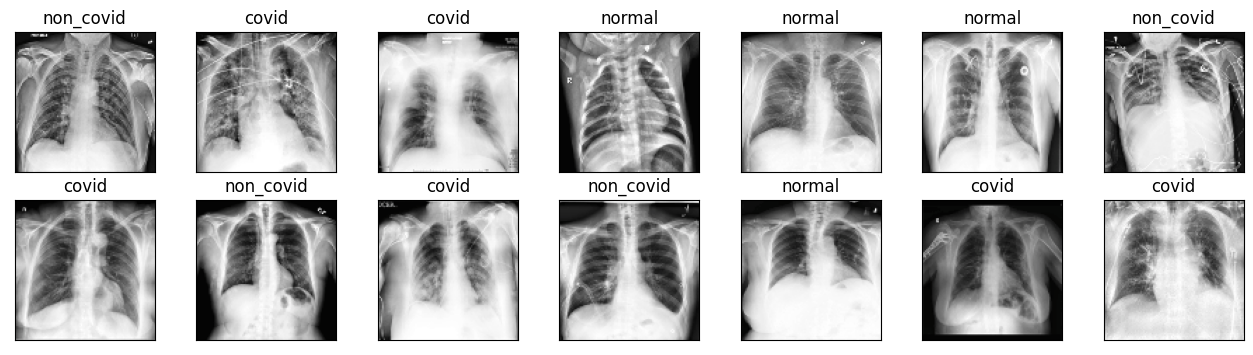

In [19]:
print('Displaying images')
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))
indices = np.random.choice(len(X_train), 14)
counter = 0
for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [20]:
X_train.shape

(3728, 100, 100, 3)

In [21]:
noncov_test,testnoncov_labels = load_noncov('D:/COVID/archive/Infection Segmentation Data/Infection Segmentation Data/Test/Non-COVID/images')

100%|███████████████████████████████████████████████████████████████████████████████| 292/292 [00:01<00:00, 159.59it/s]


In [22]:
norm_test,testnorm_labels = load_normal('D:/COVID/archive/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/images')

100%|███████████████████████████████████████████████████████████████████████████████| 291/291 [00:01<00:00, 173.78it/s]


In [23]:
covid_test,testcov_labels = load_covid('D:/COVID/archive/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images')

100%|███████████████████████████████████████████████████████████████████████████████| 583/583 [00:03<00:00, 172.32it/s]


In [24]:
X_test = np.append(norm_test,covid_test,axis=0)

In [25]:
X_test = np.append(X_test,noncov_test,axis=0)

In [26]:
y_test = np.append(testnorm_labels,testcov_labels)

In [27]:
y_test = np.append(y_test,testnoncov_labels)

In [28]:
X_test.shape

(1166, 100, 100, 3)

In [29]:
y_test.shape

(1166,)

In [30]:
norm_Val,Val_labels = load_normal('D:/COVID/archive/Infection Segmentation Data/Infection Segmentation Data/Val/Normal/images')

100%|███████████████████████████████████████████████████████████████████████████████| 233/233 [00:01<00:00, 136.09it/s]


In [31]:
covid_Val,Valcov_labels = load_covid('D:/COVID/archive/Infection Segmentation Data/Infection Segmentation Data/Val/COVID-19/images')

100%|███████████████████████████████████████████████████████████████████████████████| 466/466 [00:02<00:00, 169.91it/s]


In [32]:
noncov_Val,Valnoncov_labels = load_noncov('D:/COVID/archive/Infection Segmentation Data/Infection Segmentation Data/Val/Non-COVID/images')

100%|███████████████████████████████████████████████████████████████████████████████| 233/233 [00:01<00:00, 170.71it/s]


In [33]:
X_val = np.append(norm_Val,covid_Val,axis=0)

In [34]:
X_val = np.append(X_val,noncov_Val,axis=0)

In [35]:
y_val = np.append(Val_labels,Valcov_labels)

In [36]:
y_val = np.append(y_val,Valnoncov_labels)

In [37]:
# Create new axis on all y data
### We create this new axis since that’s just the shape expected by OneHotEncoder) 
y_train_new = y_train[:, np.newaxis]
y_test_new = y_test[:, np.newaxis]
y_val_new = y_val[:,np.newaxis]

In [38]:
# Reshape the data into (no of samples, height, width, 1), where 1 represents a single color channel
# X_train = X_train.reshape(X_train.shapea[0], X_train.shape[1], X_train.shape[2], 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2],3)

In [39]:
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train_new)
y_test_one_hot = one_hot_encoder.transform(y_test_new)
y_val_one_hot = one_hot_encoder.transform(y_val_new)

In [40]:
uniqs = np.unique(y_train)
uniq = uniqs.reshape(-1,1)

print(uniq)

newarr = one_hot_encoder.fit_transform(uniq)
newarr


[['covid']
 ['non_covid']
 ['normal']]


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [41]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))
print(np.unique(y_val, return_counts=True))

(array(['covid', 'non_covid', 'normal'], dtype='<U9'), array([1864,  932,  932], dtype=int64))
(array(['covid', 'non_covid', 'normal'], dtype='<U9'), array([583, 292, 291], dtype=int64))
(array(['covid', 'non_covid', 'normal'], dtype='<U9'), array([466, 233, 233], dtype=int64))


In [42]:
y_train_one_hot.shape

(3728, 3)

In [43]:
input_shape = (X_train.shape[1], X_train.shape[2], 3)
input_shape

(100, 100, 3)

In [44]:
X_val.shape

(932, 100, 100, 3)

In [45]:
y_val.shape

(932,)

In [46]:
print(X_train.shape)
print(y_train_one_hot.shape)

(3728, 100, 100, 3)
(3728, 3)


In [47]:
print(X_test.shape,y_test_one_hot.shape)

(1166, 100, 100, 3) (1166, 3)


In [48]:
print(X_val.shape,y_val_one_hot.shape)

(932, 100, 100, 3) (932, 3)


In [49]:
Batch_size = 64
Epochs = 100
size = 100
N_ch = 3

In [50]:
resnet50 = ResNet50(weights = "imagenet",include_top = False)

In [51]:
def build_resnet50():
    resnet50 = ResNet50(weights = "imagenet",include_top = False)
    input = Input(shape=(size,size,N_ch))
    x = Conv2D(3,(3,3),padding = "same")(input)
    x = resnet50(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256,activation="relu")(x)
    x = Dropout(0.5)(x)
    
    output = Dense(3,activation="softmax",name="root")(x)
    model = Model(input,output)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [52]:
model_resnet50 = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('ResNet50_Model_CLAHE.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,
                             horizontal_flip=True,vertical_flip=True) 

datagen.fit(X_train)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 3)       84        
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544

In [53]:
early_stop = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

In [54]:
history_resnet = model_resnet50.fit(datagen.flow(X_train, y_train_one_hot, batch_size=Batch_size),steps_per_epoch=X_train.shape[0] // Batch_size,
               epochs=Epochs,
               verbose=1,
               callbacks=[annealer, checkpoint,early_stop],
               validation_data=(X_val, y_val_one_hot))

Epoch 1/100
58/58 [==============================] - 44s 392ms/step - loss: 1.9242 - accuracy: 0.4711 - val_loss: 521034.3438 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 521034.34375, saving model to ResNet50_Model_CLAHE.hdf5


C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
58/58 [==============================] - 18s 303ms/step - loss: 1.6923 - accuracy: 0.4629 - val_loss: 45.4444 - val_accuracy: 0.4839

Epoch 00002: val_loss improved from 521034.34375 to 45.44437, saving model to ResNet50_Model_CLAHE.hdf5
Epoch 3/100
58/58 [==============================] - 18s 304ms/step - loss: 1.7061 - accuracy: 0.4372 - val_loss: 20368.3516 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 45.44437
Epoch 4/100
58/58 [==============================] - 18s 305ms/step - loss: 1.3917 - accuracy: 0.4610 - val_loss: 1.0669 - val_accuracy: 0.5032

Epoch 00004: val_loss improved from 45.44437 to 1.06686, saving model to ResNet50_Model_CLAHE.hdf5
Epoch 5/100
58/58 [==============================] - 18s 303ms/step - loss: 1.3281 - accuracy: 0.4823 - val_loss: 174.7556 - val_accuracy: 0.4142

Epoch 00005: val_loss did not improve from 1.06686
Epoch 6/100
58/58 [==============================] - 18s 305ms/step - loss: 1.1424 - accuracy: 0.5117 - val

Epoch 78/100
58/58 [==============================] - 18s 311ms/step - loss: 0.5308 - accuracy: 0.7838 - val_loss: 0.6405 - val_accuracy: 0.7468

Epoch 00078: val_loss did not improve from 0.53722
Epoch 79/100
58/58 [==============================] - 18s 305ms/step - loss: 0.5287 - accuracy: 0.7852 - val_loss: 0.5350 - val_accuracy: 0.7983

Epoch 00079: val_loss improved from 0.53722 to 0.53500, saving model to ResNet50_Model_CLAHE.hdf5
Epoch 80/100
58/58 [==============================] - 18s 305ms/step - loss: 0.5219 - accuracy: 0.7898 - val_loss: 0.6816 - val_accuracy: 0.7092

Epoch 00080: val_loss did not improve from 0.53500
Epoch 81/100
58/58 [==============================] - 18s 306ms/step - loss: 0.5216 - accuracy: 0.7912 - val_loss: 0.6735 - val_accuracy: 0.7071

Epoch 00081: val_loss did not improve from 0.53500
Epoch 82/100
58/58 [==============================] - 18s 307ms/step - loss: 0.5357 - accuracy: 0.7844 - val_loss: 0.8416 - val_accuracy: 0.6094

Epoch 00082: val_lo

In [55]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

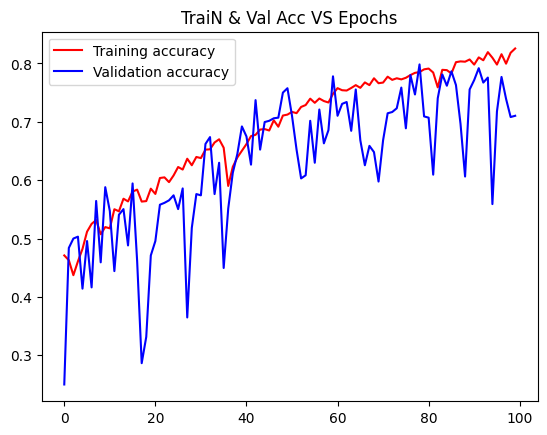

<Figure size 640x480 with 0 Axes>

In [56]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

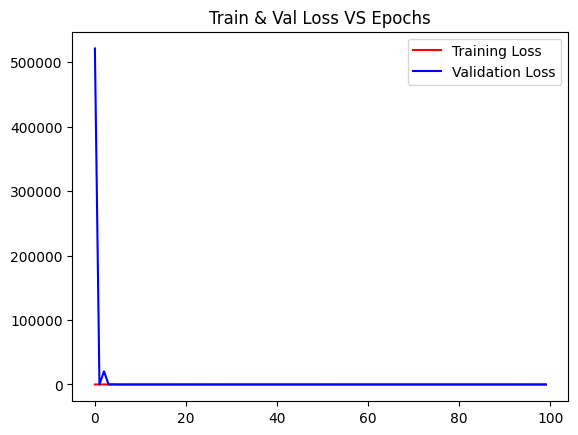

<Figure size 640x480 with 0 Axes>

In [57]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Train & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [58]:
model.load_weights("ResNet50_Model_CLAHE.hdf5")
score = model.evaluate(X_val, y_val_one_hot ,verbose=1)
print('Val Loss:', score[0])
print('Val accuracy:', score[1]*100)

30/30 [==============================] - 2s 43ms/step - loss: 0.5284 - accuracy: 0.7918
Val Loss: 0.528433620929718
Val accuracy: 79.18455004692078


In [59]:
model.load_weights("ResNet50_Model_CLAHE.hdf5")
score = model.evaluate(X_test, y_test_one_hot ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

37/37 [==============================] - 3s 88ms/step - loss: 0.5224 - accuracy: 0.8259
Test Loss: 0.5224336981773376
Test accuracy: 82.59004950523376


In [60]:
# Predicting test data
predictions = model.predict(X_test)
print(predictions)

[[0.00282095 0.5666822  0.4304968 ]
 [0.07936085 0.8829017  0.0377374 ]
 [0.12275939 0.41421878 0.46302187]
 ...
 [0.12700038 0.8562861  0.0167135 ]
 [0.5518498  0.38629314 0.06185706]
 [0.18518989 0.7922475  0.02256259]]


In [61]:
# print(one_hot_encoder.inverse_transform(predictions[0][0]))
predictions = one_hot_encoder.inverse_transform(predictions)
# print('Model evaluation')
print(one_hot_encoder.categories_)

[array(['covid', 'non_covid', 'normal'], dtype='<U9')]


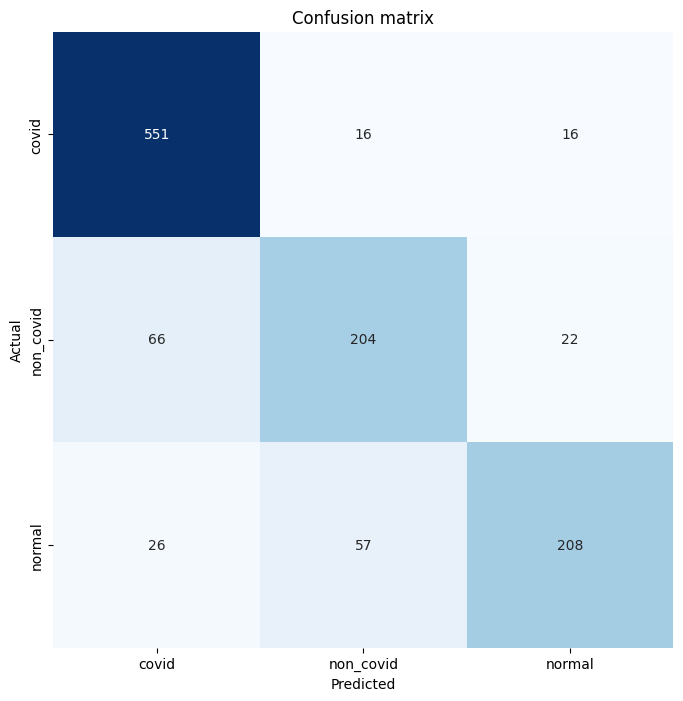

In [62]:
classnames = ['covid', 'non_covid', 'normal']
# Display confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [63]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       covid       0.86      0.95      0.90       583
   non_covid       0.74      0.70      0.72       292
      normal       0.85      0.71      0.77       291

    accuracy                           0.83      1166
   macro avg       0.81      0.79      0.80      1166
weighted avg       0.82      0.83      0.82      1166



In [64]:
confusion_matrix(y_test, predictions)

array([[551,  16,  16],
       [ 66, 204,  22],
       [ 26,  57, 208]], dtype=int64)

In [52]:
def build_VGG16():
    Vgg16 = vgg16.VGG16(weights = "imagenet",include_top = False)
    input = Input(shape=(size,size,N_ch))
    x = Conv2D(3,(3,3),padding = "same")(input)
    x = Vgg16(x)
    x = Flatten()(x)
    x = Dense(256,activation="relu")(x)
    x = Dense(128,activation="relu")(x)
    output = Dense(3,activation="softmax",name="root")(x)
    model = Model(input,output)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [53]:
model_vgg = build_VGG16()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 3)       84        
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
root (Dense)                 (None, 3)                 387   

In [54]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('vgg16_Model.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,
                             horizontal_flip=True,vertical_flip=True) 

datagen.fit(X_train)

In [55]:
history_vgg16 = model_vgg.fit(datagen.flow(X_train, y_train_one_hot, batch_size=Batch_size),steps_per_epoch=X_train.shape[0] // Batch_size,
               epochs=Epochs,verbose=1,callbacks=[annealer, checkpoint],validation_data=(X_val, y_val_one_hot))

Epoch 1/100
58/58 [==============================] - 56s 473ms/step - loss: 10.9617 - accuracy: 0.4672 - val_loss: 1.0466 - val_accuracy: 0.4989

Epoch 00001: val_loss improved from inf to 1.04663, saving model to vgg16_Model.hdf5
Epoch 2/100
58/58 [==============================] - 22s 377ms/step - loss: 1.0210 - accuracy: 0.4962 - val_loss: 0.9677 - val_accuracy: 0.4946

Epoch 00002: val_loss improved from 1.04663 to 0.96767, saving model to vgg16_Model.hdf5
Epoch 3/100
58/58 [==============================] - 22s 379ms/step - loss: 0.9834 - accuracy: 0.5126 - val_loss: 0.9515 - val_accuracy: 0.5215

Epoch 00003: val_loss improved from 0.96767 to 0.95152, saving model to vgg16_Model.hdf5
Epoch 4/100
58/58 [==============================] - 22s 378ms/step - loss: 0.9735 - accuracy: 0.5175 - val_loss: 0.9336 - val_accuracy: 0.5429

Epoch 00004: val_loss improved from 0.95152 to 0.93362, saving model to vgg16_Model.hdf5
Epoch 5/100
58/58 [==============================] - 22s 378ms/step


Epoch 00038: val_loss did not improve from 0.82086
Epoch 39/100
58/58 [==============================] - 23s 388ms/step - loss: 0.8715 - accuracy: 0.6217 - val_loss: 0.8776 - val_accuracy: 0.6255

Epoch 00039: val_loss did not improve from 0.82086
Epoch 40/100
58/58 [==============================] - 23s 388ms/step - loss: 0.8769 - accuracy: 0.6144 - val_loss: 0.8301 - val_accuracy: 0.6363

Epoch 00040: val_loss did not improve from 0.82086
Epoch 41/100
58/58 [==============================] - 23s 388ms/step - loss: 0.8572 - accuracy: 0.6228 - val_loss: 0.8058 - val_accuracy: 0.6749

Epoch 00041: val_loss improved from 0.82086 to 0.80584, saving model to vgg16_Model.hdf5
Epoch 42/100
58/58 [==============================] - 23s 388ms/step - loss: 0.8389 - accuracy: 0.6419 - val_loss: 0.8053 - val_accuracy: 0.6738

Epoch 00042: val_loss improved from 0.80584 to 0.80530, saving model to vgg16_Model.hdf5
Epoch 43/100
58/58 [==============================] - 23s 386ms/step - loss: 0.8258 

In [56]:
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

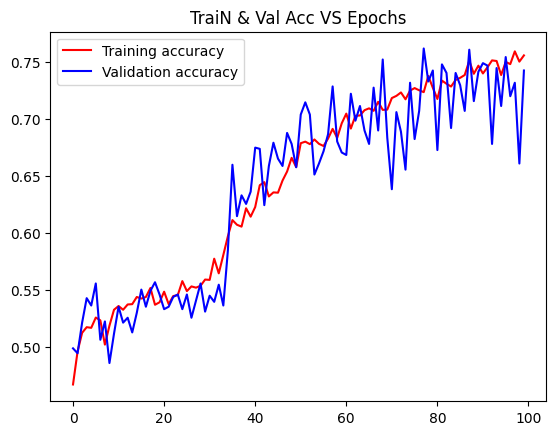

<Figure size 640x480 with 0 Axes>

In [57]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

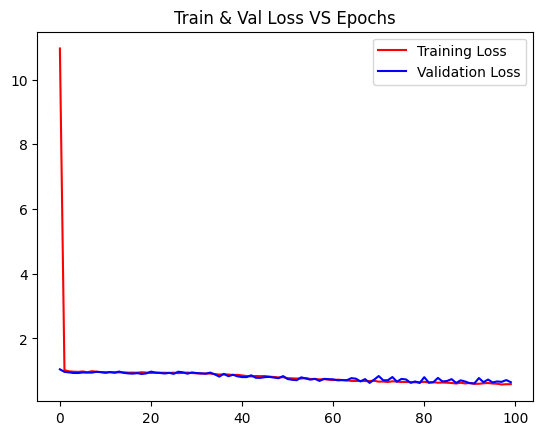

<Figure size 640x480 with 0 Axes>

In [58]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Train & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [59]:
# model.load_weights("vgg16_Model.hdf5")
score = model_vgg.evaluate(X_val, y_val_one_hot ,verbose=1)
print('Val Loss:', score[0])
print('Val accuracy:', score[1]*100)

30/30 [==============================] - 2s 57ms/step - loss: 0.6489 - accuracy: 0.7425
Val Loss: 0.648906946182251
Val accuracy: 74.24892783164978


In [60]:
# model.load_weights("vgg16_Model.hdf5")
score = model_vgg.evaluate(X_test, y_test_one_hot ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

37/37 [==============================] - 3s 89ms/step - loss: 0.5822 - accuracy: 0.7642
Test Loss: 0.5821999907493591
Test accuracy: 76.41509175300598


In [61]:
# Predicting test data
predictions = model_vgg.predict(X_test)
print(predictions)

[[1.05654625e-02 2.57628173e-01 7.31806397e-01]
 [5.08990452e-05 5.40890843e-02 9.45859969e-01]
 [1.79138798e-02 3.04276139e-01 6.77810013e-01]
 ...
 [1.35063916e-01 7.87043512e-01 7.78926015e-02]
 [8.67432132e-02 8.06374311e-01 1.06882527e-01]
 [4.97706644e-02 8.76529634e-01 7.36996531e-02]]


In [62]:
# print(one_hot_encoder.inverse_transform(predictions[0][0]))
predictions = one_hot_encoder.inverse_transform(predictions)
# print('Model evaluation')
print(one_hot_encoder.categories_)

[array(['covid', 'non_covid', 'normal'], dtype='<U9')]


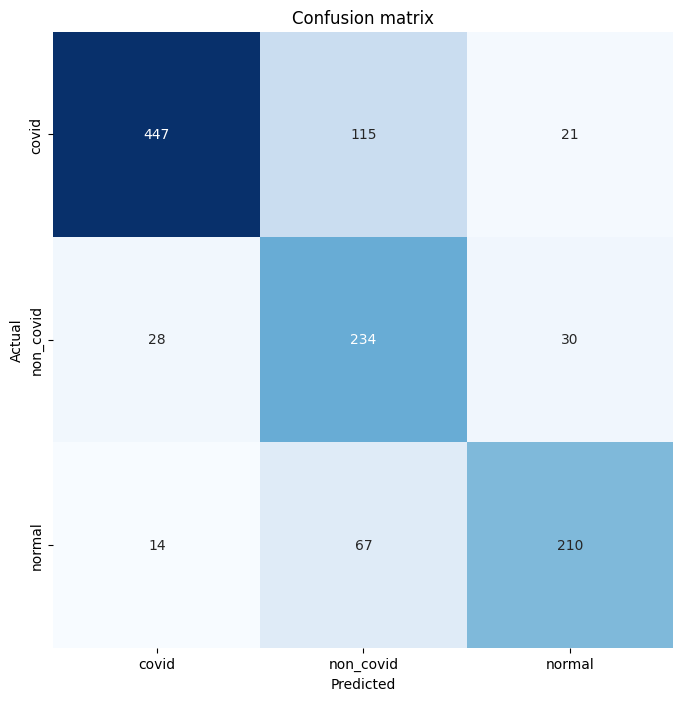

In [63]:
classnames = ['covid', 'non_covid', 'normal']
# Display confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [64]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       covid       0.91      0.77      0.83       583
   non_covid       0.56      0.80      0.66       292
      normal       0.80      0.72      0.76       291

    accuracy                           0.76      1166
   macro avg       0.76      0.76      0.75      1166
weighted avg       0.80      0.76      0.77      1166



In [50]:
def build_xception():
    xception = Xception(weights = "imagenet",include_top = False)
    input = Input(shape=(size,size,N_ch))
    x = Conv2D(3,(3,3),padding = "same")(input)
    x = xception(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256,activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(3,activation="softmax",name="root")(x)
    model = Model(input,output)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [53]:
model_xcptn = build_xception()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('xception_Model_CLAHE.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,
                             horizontal_flip=True,vertical_flip=True) 
datagen.fit(X_train)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 3)       84        
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544

In [55]:
history_Xception = model_xcptn.fit(datagen.flow(X_train, y_train_one_hot,
                                                batch_size = Batch_size)
                                   ,steps_per_epoch=X_train.shape[0] // Batch_size,
               epochs=Epochs,verbose=1,
            callbacks=[annealer, checkpoint],validation_data=(X_val, y_val_one_hot))

Epoch 1/100
58/58 [==============================] - 25s 421ms/step - loss: 1.0708 - accuracy: 0.4929 - val_loss: 1.0402 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 1.04023, saving model to xception_Model_CLAHE.hdf5


C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
58/58 [==============================] - 20s 338ms/step - loss: 1.0437 - accuracy: 0.4995 - val_loss: 1.0400 - val_accuracy: 0.5000

Epoch 00002: val_loss improved from 1.04023 to 1.04000, saving model to xception_Model_CLAHE.hdf5
Epoch 3/100
58/58 [==============================] - 20s 339ms/step - loss: 1.0456 - accuracy: 0.4989 - val_loss: 1.0417 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 1.04000
Epoch 4/100
58/58 [==============================] - 20s 342ms/step - loss: 1.0438 - accuracy: 0.4995 - val_loss: 1.0399 - val_accuracy: 0.5000

Epoch 00004: val_loss improved from 1.04000 to 1.03990, saving model to xception_Model_CLAHE.hdf5
Epoch 5/100
58/58 [==============================] - 20s 344ms/step - loss: 1.0466 - accuracy: 0.4995 - val_loss: 1.0365 - val_accuracy: 0.5000

Epoch 00005: val_loss improved from 1.03990 to 1.03650, saving model to xception_Model_CLAHE.hdf5
Epoch 6/100
58/58 [==============================] - 20s 350ms/step - loss:

58/58 [==============================] - 21s 356ms/step - loss: 0.1495 - accuracy: 0.9435 - val_loss: 0.8810 - val_accuracy: 0.7403

Epoch 00079: val_loss did not improve from 0.34500
Epoch 80/100
58/58 [==============================] - 21s 357ms/step - loss: 0.1396 - accuracy: 0.9454 - val_loss: 0.5663 - val_accuracy: 0.8112

Epoch 00080: val_loss did not improve from 0.34500
Epoch 81/100
58/58 [==============================] - 21s 356ms/step - loss: 0.1380 - accuracy: 0.9457 - val_loss: 0.5076 - val_accuracy: 0.8230

Epoch 00081: val_loss did not improve from 0.34500
Epoch 82/100
58/58 [==============================] - 21s 357ms/step - loss: 0.1479 - accuracy: 0.9471 - val_loss: 0.4763 - val_accuracy: 0.8326

Epoch 00082: val_loss did not improve from 0.34500
Epoch 83/100
58/58 [==============================] - 21s 357ms/step - loss: 0.1335 - accuracy: 0.9490 - val_loss: 0.5387 - val_accuracy: 0.8176

Epoch 00083: val_loss did not improve from 0.34500
Epoch 84/100
58/58 [========

In [56]:
acc = history_Xception.history['accuracy']
val_acc = history_Xception.history['val_accuracy']
loss = history_Xception.history['loss']
val_loss = history_Xception.history['val_loss']

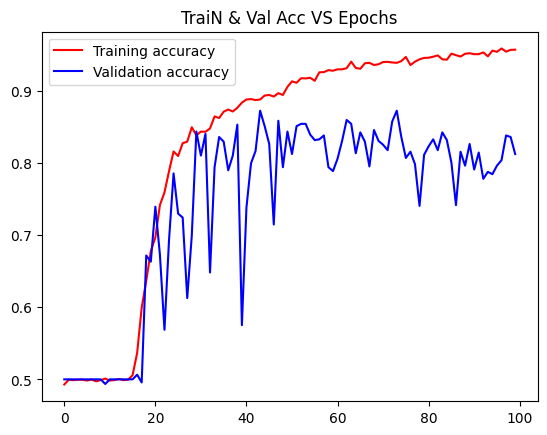

<Figure size 640x480 with 0 Axes>

In [66]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

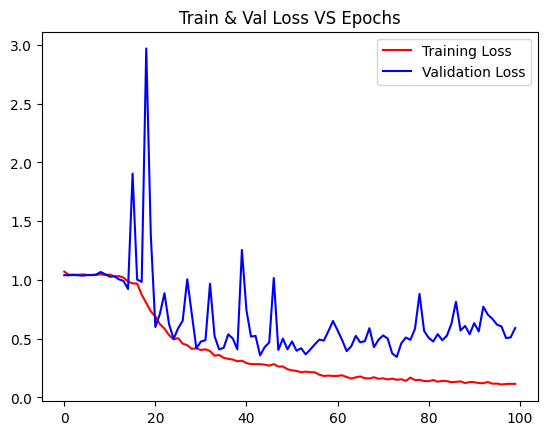

<Figure size 640x480 with 0 Axes>

In [67]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Train & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [70]:
model_xcptn.load_weights("xception_Model_CLAHE.hdf5")
score = model_xcptn.evaluate(X_val, y_val_one_hot ,verbose=1)
print('Val Loss:', score[0])
print('Val accuracy:', score[1]*100)

30/30 [==============================] - 1s 43ms/step - loss: 0.3450 - accuracy: 0.8723
Val Loss: 0.34500008821487427
Val accuracy: 87.23176121711731


In [69]:
model_xcptn.load_weights("xception_Model_CLAHE.hdf5")
score = model_xcptn.evaluate(X_test, y_test_one_hot ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

37/37 [==============================] - 2s 41ms/step - loss: 0.2092 - accuracy: 0.9288
Test Loss: 0.20924435555934906
Test accuracy: 92.88164377212524


In [71]:
# Predicting test data
predictions = model_xcptn.predict(X_test)
print(predictions)

[[4.67980746e-04 5.45341112e-02 9.44997966e-01]
 [6.01952756e-03 1.13958120e-01 8.80022347e-01]
 [2.78300722e-04 1.04377225e-01 8.95344496e-01]
 ...
 [2.33826941e-04 9.97363985e-01 2.40218709e-03]
 [5.71167469e-01 3.55063260e-01 7.37692863e-02]
 [2.50002922e-04 9.98500824e-01 1.24917447e-03]]


In [72]:
# print(one_hot_encoder.inverse_transform(predictions[0][0]))
predictions = one_hot_encoder.inverse_transform(predictions)
# print('Model evaluation')
print(one_hot_encoder.categories_)

[array(['covid', 'non_covid', 'normal'], dtype='<U9')]


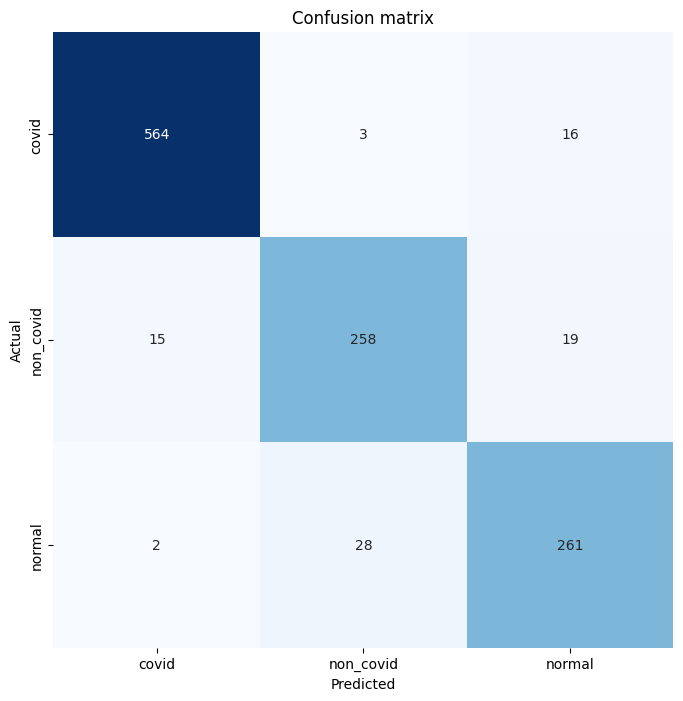

In [73]:
classnames = ['covid', 'non_covid', 'normal']
# Display confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [74]:
from sklearn.metrics import classification_report

In [75]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       covid       0.97      0.97      0.97       583
   non_covid       0.89      0.88      0.89       292
      normal       0.88      0.90      0.89       291

    accuracy                           0.93      1166
   macro avg       0.92      0.92      0.92      1166
weighted avg       0.93      0.93      0.93      1166



In [ ]:
# model_xcptn.save("xception_Model_CLAHE.hdf5")